In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import win32com.client
import sqlite3

import sys
from enum import Enum
import time
import pythoncom

# matplotlib 그래프 한글지원
import platform
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus']= False
if platform.system()== 'Windows':
    path= 'c:/Windows/Fonts/malgun.ttf'
    font_name= font_manager.FontProperties(fname=path).get_name()
    rc('font', family= font_name)
elif platform.system()=='Darwin':
    rc('font', family= 'AppleGothic')
else:
    print('포트를 지원하지 않습니다.')

In [2]:
instCpCybos= win32com.client.Dispatch("CpUtil.CpCybos")

# 연결 여부 체크
bConnect = instCpCybos.IsConnect
if (bConnect == 1):
    print("연결되었음.")
else:
    print("연결되지않음.")
    

연결되었음.


In [3]:
# 종목코드 조회
instCpStockCode= win32com.client.Dispatch("CpUtil.CpStockCode")

print('종목코드개수:', instCpStockCode.GetCount()) # 종목코드 수를 반환한다
# 해당 인덱스의 종목 데이터를 구한다 (type, index)
# type 0-종목코드, 1-종목명 , 2-FullCode
print(instCpStockCode.GetData(1,0)) # 해당 인덱스의 종목 데이터를 구한다 type: 0종목코드, 1종목명
print(instCpStockCode.GetData(0,0))
Code= instCpStockCode.NameToCode('삼성전자') # 종목명에 해당하는 code을 반환합니다. 반대 CodeToName()
Index= instCpStockCode.CodeToIndex(Code) # code에 해당하는 Index를 반환한다.
print(Code, Index)

종목코드개수: 3143
동화약품
A000020
A005930 341


In [4]:
#각종 코드정보 및 코드리스트를 얻는다.
instCpCodeMgr= win32com.client.Dispatch('CpUtil.CpCodeMgr')

codeList= instCpCodeMgr.GetStockListByMarket(1) # 코스피 종목코드를 튜플형태로 반환
kospi_list= []
for code in codeList:
    name= instCpCodeMgr.CodeToName(code)
    gubun= instCpCodeMgr.GetStockSectionKind(code) # 주권 1 ETF 10
    gubun1= instCpCodeMgr.GetStockMarketKind(code) # 코스피 1 코스닥 2
    업종= instCpCodeMgr.GetStockIndustryCode(code) # 업종구분
    업종명= instCpCodeMgr.GetIndustryName(업종) # 업종명 구분
    코스피200= instCpCodeMgr.GetStockKospi200Kind(code) # KOSPI200 여부
    관리= instCpCodeMgr.GetStockStatusKind(code) # 관리구분: 정상0, 거래정지1, 거래중단2
    상장일= instCpCodeMgr.GetStockListedDate(code)   
    kospi_list.append([code, name, gubun, gubun1, 업종, 업종명, 코스피200, 관리, 상장일])   

kospi_df= pd.DataFrame(kospi_list, columns=['종목코드','종목명','구분','소속','업종','업종명','KOSPI200','상태','상장일'])
kospi_df= kospi_df[kospi_df['구분']== 1] # ETF제외 
print(kospi_df.shape)


codeList= instCpCodeMgr.GetStockListByMarket(2) # 코스닥 종목코드를 튜플형태로 반환
kosdaq_list= []
for code in codeList:
    name= instCpCodeMgr.CodeToName(code)
    gubun= instCpCodeMgr.GetStockSectionKind(code) # 주권 1 ETF 10
    gubun1= instCpCodeMgr.GetStockMarketKind(code) # 코스피 1 코스닥 2
    업종= instCpCodeMgr.GetStockIndustryCode(code) # 업종 구분
    업종명= instCpCodeMgr.GetIndustryName(업종) # 업종명 구분
    코스피200= instCpCodeMgr.GetStockKospi200Kind(code) # KOSPI200 여부
    관리= instCpCodeMgr.GetStockStatusKind(code) # 관리구분: 정상0, 거래정지1, 거래중단2
    상장일= instCpCodeMgr.GetStockListedDate(code)   
    kosdaq_list.append([code, name, gubun, gubun1, 업종, 업종명, 코스피200, 관리, 상장일])   

kosdaq_df= pd.DataFrame(kosdaq_list, columns=['종목코드','종목명','구분','소속','업종','업종명','KOSPI200','상태','상장일'])
kosdaq_df= kosdaq_df[kosdaq_df['구분']== 1] # ETF제외 
print(kosdaq_df.shape)

(884, 9)
(1316, 9)


In [5]:
# 데이터 DB저장 
kospi_df.reset_index(inplace= True)
kospi_df.drop('index', axis=1, inplace= True)
kosdaq_df.reset_index(inplace= True)
kosdaq_df.drop('index', axis=1, inplace= True)
with sqlite3.connect('./data/StockData3.sqlite') as conn:
    kospi_df.to_sql('코스피_종목코드', con=conn, if_exists='replace', index= False) # if_exists='append'
    kosdaq_df.to_sql('코스닥_종목코드', con=conn, if_exists='replace', index= False) # if_exists='append'



In [17]:
# KOSPI200종목 필터링
kospi_df= kospi_df[kospi_df['KOSPI200']!= 0] 
kospi_df.reset_index(inplace= True)
kospi_df.drop('index', axis=1, inplace= True)
print(kospi_df.shape)
kospi_df.head()

# 1건설기계,2조선운송,3철강소재,4에너지화학,5정보통신,6금융,7필수소비재,8자유소비재,9,10제약바이오
# 종목필터링, 시가총액, 거래량, 산업구분, 감리구분(주의,경고,위험), 관리구분(거래정지여부)
# 먼저 종목코드 받은후 -> 각 종목에 대한 정보를 한번더받아 시가총액 거래량 까지 추가한다.

(190, 9)


,종목코드,종목명,구분,소속,업종,업종명,KOSPI200,상태,상장일
0,A000070,삼양홀딩스,1,1,021,금융업,7,0,19681227
1,A000080,하이트진로,1,1,005,음식료품,7,0,20091019
2,A000100,유한양행,1,1,009,의약품,10,0,19621101
3,A000120,CJ대한통운,1,1,019,운수창고,9,0,19560702
4,A000150,두산,1,1,026,서비스업,9,0,19730629


In [3]:
# 종목코드 데이터 DB불러오기 
kospi_df= None
kosdaq_df= None
with sqlite3.connect('./data/StockData3.sqlite') as conn:
    kospi_df= pd.read_sql("SELECT * From '코스피_종목코드'", con=conn) # if_exists='append'
    kosdaq_df= pd.read_sql("SELECT * From '코스닥_종목코드'", con=conn) # if_exists='append'    
print(kospi_df.shape)
print(kosdaq_df.shape)

(884, 9)
(1315, 9)


In [6]:
kospi_df= pd.concat([kospi_df, kosdaq_df])
print(kospi_df.shape)

(2199, 9)


In [4]:
# 과거데이터 구하기
# 주식, 업종, ELW의 차트데이터를 수신합니다.
def getStockChart(종목코드='', 요청구분='', 종료일='', 시작일='', 요청건수=''):
    
    inst.SetInputValue(0, 종목코드) # 0 종목코드
    inst.SetInputValue(1, ord(요청구분)) # 1 요청구분 1기간으로 요청 2 개수로 요청 #ord 문자열을 아스키값으로 변환
    if 요청구분 == '1':
        inst.SetInputValue(2, 종료일)# 2 요청종료일
        inst.SetInputValue(3, 시작일)# 3 요청시작일
    elif 요청구분 == '2':
        inst.SetInputValue(4, int(요청건수)) # 4 요청할 데이터의 개수
    else:
        return print('요청구분설정오류: 1기간 2개수')
    inst.SetInputValue(5,(0,2,3,4,5,8,9,12,13)) # 5 필드 또는 필드배열 (0,1,2,3~37, 5는 종가)
    inst.SetInputValue(6, ord('D')) # 6 차트구분 D 일
    inst.SetInputValue(9, ord('1')) # 9 수정주가 반영 유무
    
    연속조회 = True
    result=[]

    while 연속조회 == True :        
     
        # 제한을 하기 전까지의 남은 요청개수, 15초에 최대60건
        remainCount = instCpCybos.GetLimitRemainCount(1)  # 1 시세관련요청
        if remainCount <= 0: 
            print('시세 연속 조회 제한 대기:',int(instCpCybos.LimitRequestRemainTime / 1000 + 5), '초')
            time.sleep(instCpCybos.LimitRequestRemainTime / 1000 + 5)

        inst.BlockRequest()
        
        #현재가 통신 및 통신 에러 처리
        rqStatus = inst.GetDibStatus()
        #print('통신상태', rqStatus, objRq.GetDibMsg1())
        if rqStatus != 0:
            print('통신실패')
            break 

        numData= inst.GetHeaderValue(3) # 3 수신개수
        numField= inst.GetHeaderValue(1) # 1 필드개수
        print('행:',numData,'열:',numField, end=' ')

        for i in range(numData):
            날짜= str(inst.GetDataValue(0,i))
            시가= int(inst.GetDataValue(1,i))
            고가= int(inst.GetDataValue(2,i))
            저가= int(inst.GetDataValue(3,i))
            종가= int(inst.GetDataValue(4,i))
            거래량= float(inst.GetDataValue(5,i))
            거래대금= float(inst.GetDataValue(6,i))
            상장주식수= float(inst.GetDataValue(7,i))
            시가총액= float(inst.GetDataValue(8,i))
            # 종목코드
            result.append([종목코드,날짜,시가,고가,저가,종가,거래량,거래대금,상장주식수,시가총액])         

        if inst.Continue != True:
            연속조회 = False
            break
            
       
    df_local= pd.DataFrame(result, columns=['종목코드','날짜','시가','고가','저가','종가',
                                      '거래량','거래대금','상장주식수','시가총액'])   
    print(종목코드,'조회완료',df_local.shape)
            
    return df_local


In [5]:
inst= win32com.client.Dispatch('CpSysDib.StockChart')

#df= getStockChart(종목코드='A022100', 요청구분='1', 종료일='20100208', 시작일='20020208') # 최대 9년
#df= getStockChart(종목코드='A005930', 요청구분='2', 요청건수= '2000') 
#날짜, 시가, 고가, 저가, 종가, 거래량, 거래대금, 상장주식수, 시가총액

# 버그: 요청건수3000개이상일때 최대건수로 다운로드
# 'A001260', 'A015540', 'A025620', 'A005880', 'A071970' ???? 1000만원이상값 버그는 아니고 수정주가 때문인것같다.


In [17]:
# 전체 다운로드 (최초1회)
df= None
df0= None
cnt= 0

#for code in kosdaq_df['종목코드'].values:
for code in kospi_df['종목코드'].values:
    # df0 = getStockChart(종목코드= code, 요청구분='2', 요청건수= '3000')
    df0= getStockChart(종목코드= code, 요청구분='1', 종료일='20190416', 시작일='20090101')
    time.sleep(0.5)
    df= pd.concat([df, df0])
    cnt= cnt+1
    print(cnt)
#     if df0.shape[0] == 2000: # 요청건수 2000개 데이터가 있는 종목만 받는다.
#         df= pd.concat([df, df0])
#         cnt= cnt+1
#         print(cnt)
# df의 행이 400만개 넘어가면 오류발생함.      
print(df.shape)
#print(df.shape[0] / 4233)


행: 2221 열: 9 행: 323 열: 9 A000020 조회완료 (2544, 10)
1
행: 2221 열: 9 행: 323 열: 9 A000040 조회완료 (2544, 10)
2
행: 2221 열: 9 행: 323 열: 9 A000050 조회완료 (2544, 10)
3
행: 2221 열: 9 행: 323 열: 9 A000060 조회완료 (2544, 10)
4
행: 2221 열: 9 행: 323 열: 9 A000070 조회완료 (2544, 10)
5
행: 2221 열: 9 행: 323 열: 9 A000075 조회완료 (2544, 10)
6
행: 2221 열: 9 행: 122 열: 9 A000080 조회완료 (2343, 10)
7
행: 1860 열: 9 A000087 조회완료 (1860, 10)
8
행: 2221 열: 9 행: 323 열: 9 A000100 조회완료 (2544, 10)
9
행: 2221 열: 9 행: 323 열: 9 A000105 조회완료 (2544, 10)
10
행: 2221 열: 9 행: 323 열: 9 A000120 조회완료 (2544, 10)
11
행: 2221 열: 9 행: 323 열: 9 A000140 조회완료 (2544, 10)
12
행: 2221 열: 9 행: 323 열: 9 A000145 조회완료 (2544, 10)
13
행: 2221 열: 9 행: 323 열: 9 A000150 조회완료 (2544, 10)
14
행: 2221 열: 9 행: 323 열: 9 A000155 조회완료 (2544, 10)
15
행: 2221 열: 9 행: 323 열: 9 A000157 조회완료 (2544, 10)
16
행: 2221 열: 9 행: 323 열: 9 A000180 조회완료 (2544, 10)
17
행: 2221 열: 9 행: 323 열: 9 A000210 조회완료 (2544, 10)
18
행: 2221 열: 9 행: 323 열: 9 A000215 조회완료 (2544, 10)
19
행: 2221 열: 9 행: 323 열: 9 A000220 

158
행: 2221 열: 9 행: 323 열: 9 A002787 조회완료 (2544, 10)
159
행: 2221 열: 9 행: 323 열: 9 A002790 조회완료 (2544, 10)
160
행: 2221 열: 9 행: 323 열: 9 A002795 조회완료 (2544, 10)
161
행: 2221 열: 9 행: 323 열: 9 A002810 조회완료 (2544, 10)
162
행: 2221 열: 9 행: 323 열: 9 A002820 조회완료 (2544, 10)
163
행: 2221 열: 9 행: 323 열: 9 A002840 조회완료 (2544, 10)
164
행: 2221 열: 9 행: 323 열: 9 A002870 조회완료 (2544, 10)
165
행: 2221 열: 9 행: 323 열: 9 A002880 조회완료 (2544, 10)
166
행: 2221 열: 9 행: 323 열: 9 A002900 조회완료 (2544, 10)
167
행: 2221 열: 9 행: 323 열: 9 A002920 조회완료 (2544, 10)
168
행: 2221 열: 9 행: 323 열: 9 A002960 조회완료 (2544, 10)
169
행: 2221 열: 9 행: 323 열: 9 A002990 조회완료 (2544, 10)
170
행: 2221 열: 9 행: 323 열: 9 A002995 조회완료 (2544, 10)
171
행: 2221 열: 9 행: 323 열: 9 A003000 조회완료 (2544, 10)
172
행: 2221 열: 9 행: 323 열: 9 A003010 조회완료 (2544, 10)
173
행: 2221 열: 9 행: 323 열: 9 A003030 조회완료 (2544, 10)
174
행: 2221 열: 9 행: 323 열: 9 A003060 조회완료 (2544, 10)
175
행: 2221 열: 9 행: 323 열: 9 A003070 조회완료 (2544, 10)
176
행: 2221 열: 9 행: 323 열: 9 A003075 조회완료 (254

314
행: 2221 열: 9 행: 323 열: 9 A005960 조회완료 (2544, 10)
315
행: 2221 열: 9 행: 323 열: 9 A005965 조회완료 (2544, 10)
316
행: 2221 열: 9 행: 323 열: 9 A006040 조회완료 (2544, 10)
317
행: 2221 열: 9 행: 323 열: 9 A006060 조회완료 (2544, 10)
318
행: 2221 열: 9 행: 323 열: 9 A006090 조회완료 (2544, 10)
319
행: 2221 열: 9 행: 323 열: 9 A006110 조회완료 (2544, 10)
320
행: 2221 열: 9 행: 323 열: 9 A006120 조회완료 (2544, 10)
321
행: 2221 열: 9 행: 323 열: 9 A006125 조회완료 (2544, 10)
322
행: 2221 열: 9 행: 323 열: 9 A006200 조회완료 (2544, 10)
323
행: 2221 열: 9 행: 323 열: 9 A006220 조회완료 (2544, 10)
324
행: 2221 열: 9 행: 323 열: 9 A006260 조회완료 (2544, 10)
325
행: 2221 열: 9 행: 323 열: 9 A006280 조회완료 (2544, 10)
326
행: 2221 열: 9 행: 323 열: 9 A006340 조회완료 (2544, 10)
327
행: 2221 열: 9 행: 323 열: 9 A006345 조회완료 (2544, 10)
328
행: 2221 열: 9 행: 323 열: 9 A006360 조회완료 (2544, 10)
329
행: 2221 열: 9 행: 323 열: 9 A006370 조회완료 (2544, 10)
330
행: 2221 열: 9 행: 323 열: 9 A006380 조회완료 (2544, 10)
331
행: 2221 열: 9 행: 323 열: 9 A006390 조회완료 (2544, 10)
332
행: 2221 열: 9 행: 323 열: 9 A006400 조회완료 (254

471
행: 2221 열: 9 행: 323 열: 9 A012330 조회완료 (2544, 10)
472
행: 2221 열: 9 행: 323 열: 9 A012450 조회완료 (2544, 10)
473
행: 2221 열: 9 행: 323 열: 9 A012510 조회완료 (2544, 10)
474
행: 2221 열: 9 행: 323 열: 9 A012600 조회완료 (2544, 10)
475
행: 2221 열: 9 행: 323 열: 9 A012610 조회완료 (2544, 10)
476
행: 2221 열: 9 행: 323 열: 9 A012630 조회완료 (2544, 10)
477
행: 2221 열: 9 행: 323 열: 9 A012690 조회완료 (2544, 10)
478
행: 2221 열: 9 행: 323 열: 9 A012750 조회완료 (2544, 10)
479
행: 2221 열: 9 행: 323 열: 9 A012800 조회완료 (2544, 10)
480
행: 2221 열: 9 행: 323 열: 9 A013000 조회완료 (2544, 10)
481
행: 2221 열: 9 행: 323 열: 9 A013360 조회완료 (2544, 10)
482
행: 2221 열: 9 행: 323 열: 9 A013520 조회완료 (2544, 10)
483
행: 2221 열: 9 행: 323 열: 9 A013570 조회완료 (2544, 10)
484
행: 2221 열: 9 행: 323 열: 9 A013580 조회완료 (2544, 10)
485
행: 2221 열: 9 행: 323 열: 9 A013700 조회완료 (2544, 10)
486
행: 1571 열: 9 A013870 조회완료 (1571, 10)
487
행: 2221 열: 9 행: 323 열: 9 A014130 조회완료 (2544, 10)
488
행: 2221 열: 9 행: 323 열: 9 A014160 조회완료 (2544, 10)
489
행: 2221 열: 9 행: 323 열: 9 A014280 조회완료 (2544, 10)
490
행

792
행: 2190 열: 9 A123700 조회완료 (2190, 10)
793
행: 675 열: 9 A123890 조회완료 (675, 10)
794
행: 2046 열: 9 A126560 조회완료 (2046, 10)
795
행: 2147 열: 9 A128820 조회완료 (2147, 10)
796
행: 2147 열: 9 A128940 조회완료 (2147, 10)
797
행: 1802 열: 9 A129260 조회완료 (1802, 10)
798
행: 2051 열: 9 A130660 조회완료 (2051, 10)
799
행: 1161 열: 9 A133820 조회완료 (1161, 10)
800
행: 2012 열: 9 A134380 조회완료 (2012, 10)
801
행: 2024 열: 9 A134790 조회완료 (2024, 10)
802
행: 2011 열: 9 A136490 조회완료 (2011, 10)
803
행: 1952 열: 9 A138040 조회완료 (1952, 10)
804
행: 995 열: 9 A138250 조회완료 (995, 10)
805
행: 1930 열: 9 A138490 조회완료 (1930, 10)
806
행: 1982 열: 9 A138930 조회완료 (1982, 10)
807
행: 1936 열: 9 A139130 조회완료 (1936, 10)
808
행: 1933 열: 9 A139480 조회완료 (1933, 10)
809
행: 578 열: 9 A143210 조회완료 (578, 10)
810
행: 1727 열: 9 A144620 조회완료 (1727, 10)
811
행: 1001 열: 9 A145210 조회완료 (1001, 10)
812
행: 509 열: 9 A145720 조회완료 (509, 10)
813
행: 1811 열: 9 A145990 조회완료 (1811, 10)
814
행: 1811 열: 9 A145995 조회완료 (1811, 10)
815
행: 806 열: 9 A152330 조회완료 (806, 10)
816
행: 1452 열: 9 A155660 조

In [18]:
df.shape

(2022254, 10)

In [19]:
df.head()

,종목코드,날짜,시가,고가,저가,종가,거래량,거래대금,상장주식수,시가총액
0,A000020,20190416,9690,9770,9610,9710,31108.0,3.020000e+08,27931000.0,2.712100e+11
1,A000020,20190415,9570,9890,9480,9690,104176.0,1.005000e+09,27931000.0,2.706510e+11
2,A000020,20190412,9490,9660,9370,9600,60392.0,5.780000e+08,27931000.0,2.681370e+11
3,A000020,20190411,9440,9590,9340,9490,81137.0,7.660000e+08,27931000.0,2.650650e+11
4,A000020,20190410,9390,9420,9250,9390,68686.0,6.430000e+08,27931000.0,2.622720e+11


In [20]:
# 데이터 DB저장 
df.reset_index(inplace= True)
df.drop('index', axis=1, inplace= True)
with sqlite3.connect('./data/StockData3.sqlite') as conn:
    df.to_sql('코스피_일별주가', con=conn, if_exists='replace', index= False) # if_exists='append'
    #df.to_sql('코스닥_일별주가', con=conn, if_exists='replace', index= False) # if_exists='append'
    #df.to_sql('기간별_주가', con=conn, if_exists='replace', index= False) # if_exists='append'

In [6]:
# 부분 데이터 업데이트
with sqlite3.connect('./data/StockData3.sqlite') as conn:
    df_org= pd.read_sql("SELECT * From '코스닥_일별주가'", con=conn) # if_exists='append'

df= None
cnt= 0
for code in df_org.종목코드.unique():
    df0 = getStockChart(종목코드= code, 요청구분='2', 요청건수= '10')
    time.sleep(0.1)
    df= pd.concat([df, df0])
    cnt= cnt+1
    print(cnt)
    
print(df.shape)
print(df.shape[0] / 2)

행: 10 열: 9 A000250 조회완료 (10, 10)
1
행: 10 열: 9 A000440 조회완료 (10, 10)
2
행: 10 열: 9 A001000 조회완료 (10, 10)
3
행: 10 열: 9 A001540 조회완료 (10, 10)
4
행: 10 열: 9 A001810 조회완료 (10, 10)
5
행: 10 열: 9 A001840 조회완료 (10, 10)
6
행: 10 열: 9 A002230 조회완료 (10, 10)
7
행: 10 열: 9 A002290 조회완료 (10, 10)
8
행: 10 열: 9 A002680 조회완료 (10, 10)
9
행: 10 열: 9 A002800 조회완료 (10, 10)
10
행: 10 열: 9 A003100 조회완료 (10, 10)
11
행: 10 열: 9 A003310 조회완료 (10, 10)
12
행: 10 열: 9 A003380 조회완료 (10, 10)
13
행: 10 열: 9 A003670 조회완료 (10, 10)
14
행: 10 열: 9 A003800 조회완료 (10, 10)
15
행: 10 열: 9 A004590 조회완료 (10, 10)
16
행: 10 열: 9 A004650 조회완료 (10, 10)
17
행: 10 열: 9 A004780 조회완료 (10, 10)
18
행: 10 열: 9 A005160 조회완료 (10, 10)
19
행: 10 열: 9 A005290 조회완료 (10, 10)
20
행: 10 열: 9 A005670 조회완료 (10, 10)
21
행: 10 열: 9 A005710 조회완료 (10, 10)
22
행: 10 열: 9 A005860 조회완료 (10, 10)
23
행: 10 열: 9 A005990 조회완료 (10, 10)
24
행: 10 열: 9 A006050 조회완료 (10, 10)
25
행: 10 열: 9 A006140 조회완료 (10, 10)
26
행: 10 열: 9 A006580 조회완료 (10, 10)
27
행: 10 열: 9 A006620 조회완료 (10, 10)
28
행

224
행: 10 열: 9 A035460 조회완료 (10, 10)
225
행: 10 열: 9 A035480 조회완료 (10, 10)
226
행: 10 열: 9 A035600 조회완료 (10, 10)
227
행: 10 열: 9 A035610 조회완료 (10, 10)
228
행: 10 열: 9 A035620 조회완료 (10, 10)
229
행: 10 열: 9 A035760 조회완료 (10, 10)
230
행: 10 열: 9 A035810 조회완료 (10, 10)
231
행: 10 열: 9 A035890 조회완료 (10, 10)
232
행: 10 열: 9 A035900 조회완료 (10, 10)
233
행: 10 열: 9 A036000 조회완료 (10, 10)
234
행: 10 열: 9 A036010 조회완료 (10, 10)
235
행: 10 열: 9 A036030 조회완료 (10, 10)
236
행: 10 열: 9 A036090 조회완료 (10, 10)
237
행: 10 열: 9 A036120 조회완료 (10, 10)
238
행: 10 열: 9 A036170 조회완료 (10, 10)
239
행: 10 열: 9 A036180 조회완료 (10, 10)
240
시세 연속 조회 제한 대기: 12 초
행: 10 열: 9 A036190 조회완료 (10, 10)
241
행: 10 열: 9 A036200 조회완료 (10, 10)
242
행: 10 열: 9 A036260 조회완료 (10, 10)
243
행: 10 열: 9 A036420 조회완료 (10, 10)
244
행: 10 열: 9 A036480 조회완료 (10, 10)
245
행: 10 열: 9 A036490 조회완료 (10, 10)
246
행: 10 열: 9 A036540 조회완료 (10, 10)
247
행: 10 열: 9 A036560 조회완료 (10, 10)
248
행: 10 열: 9 A036620 조회완료 (10, 10)
249
행: 10 열: 9 A036630 조회완료 (10, 10)
250
행: 10 열: 9 A0

444
행: 10 열: 9 A053060 조회완료 (10, 10)
445
행: 10 열: 9 A053110 조회완료 (10, 10)
446
행: 10 열: 9 A053160 조회완료 (10, 10)
447
행: 10 열: 9 A053260 조회완료 (10, 10)
448
행: 10 열: 9 A053270 조회완료 (10, 10)
449
행: 10 열: 9 A053280 조회완료 (10, 10)
450
행: 10 열: 9 A053290 조회완료 (10, 10)
451
행: 10 열: 9 A053300 조회완료 (10, 10)
452
행: 10 열: 9 A053350 조회완료 (10, 10)
453
행: 10 열: 9 A053450 조회완료 (10, 10)
454
행: 10 열: 9 A053580 조회완료 (10, 10)
455
행: 10 열: 9 A053590 조회완료 (10, 10)
456
행: 10 열: 9 A053610 조회완료 (10, 10)
457
행: 10 열: 9 A053620 조회완료 (10, 10)
458
행: 10 열: 9 A053660 조회완료 (10, 10)
459
행: 10 열: 9 A053700 조회완료 (10, 10)
460
행: 10 열: 9 A053800 조회완료 (10, 10)
461
행: 10 열: 9 A053950 조회완료 (10, 10)
462
행: 10 열: 9 A053980 조회완료 (10, 10)
463
행: 10 열: 9 A054040 조회완료 (10, 10)
464
행: 10 열: 9 A054050 조회완료 (10, 10)
465
행: 10 열: 9 A054090 조회완료 (10, 10)
466
행: 10 열: 9 A054180 조회완료 (10, 10)
467
행: 10 열: 9 A054210 조회완료 (10, 10)
468
행: 10 열: 9 A054220 조회완료 (10, 10)
469
행: 10 열: 9 A054300 조회완료 (10, 10)
470
행: 10 열: 9 A054340 조회완료 (10, 10)
4

664
행: 10 열: 9 A079650 조회완료 (10, 10)
665
행: 10 열: 9 A079810 조회완료 (10, 10)
666
행: 10 열: 9 A079940 조회완료 (10, 10)
667
행: 10 열: 9 A079950 조회완료 (10, 10)
668
행: 10 열: 9 A079960 조회완료 (10, 10)
669
행: 10 열: 9 A079970 조회완료 (10, 10)
670
행: 10 열: 9 A080000 조회완료 (10, 10)
671
행: 10 열: 9 A080010 조회완료 (10, 10)
672
행: 10 열: 9 A080160 조회완료 (10, 10)
673
행: 10 열: 9 A080220 조회완료 (10, 10)
674
행: 10 열: 9 A080420 조회완료 (10, 10)
675
행: 10 열: 9 A080440 조회완료 (10, 10)
676
행: 10 열: 9 A080470 조회완료 (10, 10)
677
행: 10 열: 9 A080520 조회완료 (10, 10)
678
행: 10 열: 9 A080530 조회완료 (10, 10)
679
행: 10 열: 9 A080580 조회완료 (10, 10)
680
행: 10 열: 9 A080720 조회완료 (10, 10)
681
행: 10 열: 9 A081150 조회완료 (10, 10)
682
행: 10 열: 9 A081580 조회완료 (10, 10)
683
행: 10 열: 9 A082210 조회완료 (10, 10)
684
행: 10 열: 9 A082270 조회완료 (10, 10)
685
행: 10 열: 9 A082660 조회완료 (10, 10)
686
행: 10 열: 9 A082800 조회완료 (10, 10)
687
행: 10 열: 9 A082850 조회완료 (10, 10)
688
행: 10 열: 9 A082920 조회완료 (10, 10)
689
행: 10 열: 9 A083310 조회완료 (10, 10)
690
행: 10 열: 9 A083450 조회완료 (10, 10)
6

884
행: 10 열: 9 A115440 조회완료 (10, 10)
885
행: 10 열: 9 A115450 조회완료 (10, 10)
886
행: 10 열: 9 A115480 조회완료 (10, 10)
887
행: 10 열: 9 A115500 조회완료 (10, 10)
888
행: 10 열: 9 A115530 조회완료 (10, 10)
889
행: 10 열: 9 A115570 조회완료 (10, 10)
890
행: 10 열: 9 A115610 조회완료 (10, 10)
891
행: 10 열: 9 A115960 조회완료 (10, 10)
892
행: 10 열: 9 A117670 조회완료 (10, 10)
893
행: 10 열: 9 A117730 조회완료 (10, 10)
894
행: 10 열: 9 A118990 조회완료 (10, 10)
895
행: 10 열: 9 A119500 조회완료 (10, 10)
896
행: 10 열: 9 A119610 조회완료 (10, 10)
897
행: 10 열: 9 A119830 조회완료 (10, 10)
898
행: 10 열: 9 A119850 조회완료 (10, 10)
899
행: 10 열: 9 A119860 조회완료 (10, 10)
900
시세 연속 조회 제한 대기: 12 초
행: 10 열: 9 A120240 조회완료 (10, 10)
901
행: 10 열: 9 A121440 조회완료 (10, 10)
902
행: 10 열: 9 A121600 조회완료 (10, 10)
903
행: 10 열: 9 A121800 조회완료 (10, 10)
904
행: 10 열: 9 A121850 조회완료 (10, 10)
905
행: 10 열: 9 A121890 조회완료 (10, 10)
906
행: 10 열: 9 A122310 조회완료 (10, 10)
907
행: 10 열: 9 A122350 조회완료 (10, 10)
908
행: 10 열: 9 A122450 조회완료 (10, 10)
909
행: 10 열: 9 A122640 조회완료 (10, 10)
910
행: 10 열: 9 A1

1102
행: 10 열: 9 A208710 조회완료 (10, 10)
1103
행: 10 열: 9 A208860 조회완료 (10, 10)
1104
행: 10 열: 9 A211270 조회완료 (10, 10)
1105
행: 10 열: 9 A212560 조회완료 (10, 10)
1106
행: 10 열: 9 A213090 조회완료 (10, 10)
1107
행: 10 열: 9 A213420 조회완료 (10, 10)
1108
행: 10 열: 9 A214150 조회완료 (10, 10)
1109
행: 10 열: 9 A214180 조회완료 (10, 10)
1110
행: 10 열: 9 A214270 조회완료 (10, 10)
1111
행: 10 열: 9 A214310 조회완료 (10, 10)
1112
행: 10 열: 9 A214370 조회완료 (10, 10)
1113
행: 10 열: 9 A214430 조회완료 (10, 10)
1114
행: 10 열: 9 A214450 조회완료 (10, 10)
1115
행: 10 열: 9 A214680 조회완료 (10, 10)
1116
행: 10 열: 9 A214870 조회완료 (10, 10)
1117
행: 10 열: 9 A215000 조회완료 (10, 10)
1118
행: 10 열: 9 A215090 조회완료 (10, 10)
1119
행: 10 열: 9 A215100 조회완료 (10, 10)
1120
행: 10 열: 9 A215200 조회완료 (10, 10)
1121
행: 10 열: 9 A215360 조회완료 (10, 10)
1122
행: 10 열: 9 A215380 조회완료 (10, 10)
1123
행: 10 열: 9 A215480 조회완료 (10, 10)
1124
행: 10 열: 9 A215600 조회완료 (10, 10)
1125
행: 10 열: 9 A215790 조회완료 (10, 10)
1126
행: 10 열: 9 A216050 조회완료 (10, 10)
1127
행: 10 열: 9 A217190 조회완료 (10, 10)
1128
행: 10 열

In [8]:
print(df_org.날짜.max())
print(df.날짜.min())

20190426
20190418


In [13]:
df.isnull().any()

종목코드     False
날짜       False
시가       False
고가       False
저가       False
종가       False
거래량      False
거래대금     False
상장주식수    False
시가총액     False
dtype: bool

In [10]:
# df_org= df_org[df_org['날짜'] != df_org.날짜.max()] # 마지막날짜 삭제
# 메모리 문제 해결방안은??
# array로 바꾼다음에 append로 추가한다.
# sql의 append기능을 사용한다.
# df_org[df_org.날짜 == df_org.날짜.max()].index

In [36]:
col_list= list(df.columns.values)
df_tmp= pd.merge(df_org, df, left_on=col_list, right_on=col_list, how='outer') # 기존 데이터와 새롭게 받은 데이터 붙인다.(중복삭제)
print(df_tmp.shape)
df_tmp.tail()

(2504849, 10)


,종목코드,날짜,시가,고가,저가,종가,거래량,거래대금,상장주식수,시가총액
2504844,A317030,20190507,2030,2040,2030,2035,6110.0,12000000.0,5461000.0,1.111300e+10
2504845,A317030,20190503,2025,2035,2020,2030,92171.0,187000000.0,5461000.0,1.108500e+10
2504846,A317030,20190502,2020,2025,2015,2020,122229.0,247000000.0,5461000.0,1.103100e+10
2504847,A317030,20190430,2020,2025,2020,2020,78874.0,159000000.0,5461000.0,1.103100e+10
2504848,A317030,20190429,2020,2025,2015,2020,56263.0,114000000.0,5461000.0,1.103100e+10


In [37]:
# 데이터 DB저장 
#df_tmp.reset_index(inplace= True)
#df_tmp.drop('index', axis=1, inplace= True)
#del df_tmp['index']
with sqlite3.connect('./data/StockData3.sqlite') as conn:
    df_tmp.to_sql('코스닥_일별주가', con=conn, if_exists='replace', index= False) # if_exists='append'

In [43]:
df.shape

(13150, 10)

In [20]:
#  날짜, 외인, 기관, 개인 순매수수량 또는 비중
# 1회에 17건씩 가져온다. 최대 3737일을 가져온다.
def getCpSvr7254(종목코드='', 요청건수='', 비중= False):
    
    요청건수= int(요청건수)  
    objRq.SetInputValue(0, 종목코드)
    objRq.SetInputValue(1, 6)  # 0:사용자지정 6: 일자별
#     objRq.SetInputValue(2, int(시작일))# 2 요청시작일
#     objRq.SetInputValue(3, int(종료일))# 3 요청종료일
    objRq.SetInputValue(4, ord('0'))  # '0' 순매수 '1' 매매비중
    objRq.SetInputValue(5, 0)  # '전체
    objRq.SetInputValue(6, ord('1'))  # '1' 순매수량 '2' 추정금액(백만)
    
    연속조회 = True
    result=[]
    sum_cnt=0

    while 연속조회 == True :
        
        # 제한을 하기 전까지의 남은 요청개수, 15초에 최대60건
        remainCount = instCpCybos.GetLimitRemainCount(1)  # 1 시세관련요청
        if remainCount <= 0: 
            print('시세 연속 조회 제한 대기:',int(instCpCybos.LimitRequestRemainTime / 1000 + 10), '초')
            time.sleep(instCpCybos.LimitRequestRemainTime / 1000 + 10)
        time.sleep(0.1)

        objRq.BlockRequest()
        
        # 현재가 통신 및 통신 에러 처리
        rqStatus = objRq.GetDibStatus()
        #print('통신상태', rqStatus, objRq.GetDibMsg1())
        if rqStatus != 0:
            print('통신실패')
            break    
            
        numData= objRq.GetHeaderValue(1) # 1 필드개수
        #print('행:',numData)
        sum_cnt += numData
    
    
        for i in range(numData):
            날짜 = str(objRq.GetDataValue(0, i))
            개인 = objRq.GetDataValue(1, i)
            외국인 = objRq.GetDataValue(2, i)
            기관계 = objRq.GetDataValue(3, i)
            금융투자 = objRq.GetDataValue(4, i)
            보험= objRq.GetDataValue(5, i)
            투신 = objRq.GetDataValue(6, i)
            은행 = objRq.GetDataValue(7, i)
            기타금융 = objRq.GetDataValue(8, i)
            연기금등 = objRq.GetDataValue(9, i) # 201812월 개정
            # 국가지자체 = objRq.GetDataValue(13, i) # 201812월 개정
            사모펀드 = objRq.GetDataValue(12, i)
            기타법인 = objRq.GetDataValue(10, i)
            기타외인 = objRq.GetDataValue(11, i)

            #종목코드
            result.append([종목코드,날짜,개인,외국인,기관계,금융투자,보험,투신,은행,기타금융,연기금등,사모펀드,기타법인,기타외인])  
            
        if (objRq.Continue != True) or (sum_cnt >= 요청건수): 
            연속조회 = False
            break
     

    df_local= pd.DataFrame(result, columns=('종목코드', '날짜', '개인', '외국인', '기관계',
                           '금융투자', '보험', '투신', '은행', '기타금융', '연기금등', '사모펀드',
                           '기타법인', '기타외인'))    
    print(종목코드,'조회완료', df_local.shape)
            
    return df_local


In [21]:
objRq = win32com.client.Dispatch('CpSysDib.CpSvr7254')
df1= getCpSvr7254(종목코드='A005930', 요청건수='2000', 비중= False) # 순매수량 


시세 연속 조회 제한 대기: 17 초
A005930 조회완료 (2006, 14)


In [24]:
with sqlite3.connect('./data/StockData.sqlite') as conn:
    df= pd.read_sql("SELECT * From '기간별주가'", con=conn) # if_exists='append'

In [22]:
print(df.shape)
df.종목코드.unique()

(322000, 10)


array(['A000070', 'A000080', 'A000100', 'A000120', 'A000150', 'A000210',
       'A000240', 'A000270', 'A000640', 'A000660', 'A000670', 'A000720',
       'A000810', 'A000880', 'A000990', 'A001040', 'A001060', 'A001120',
       'A001230', 'A001430', 'A001450', 'A001520', 'A001680', 'A001740',
       'A001800', 'A002240', 'A002270', 'A002350', 'A002380', 'A002790',
       'A002960', 'A003000', 'A003240', 'A003300', 'A003410', 'A003490',
       'A003520', 'A003550', 'A003620', 'A003850', 'A003920', 'A004000',
       'A004020', 'A004170', 'A004370', 'A004490', 'A004800', 'A004990',
       'A005180', 'A005250', 'A005300', 'A005380', 'A005440', 'A005490',
       'A005610', 'A005830', 'A005850', 'A005930', 'A005940', 'A006120',
       'A006260', 'A006280', 'A006360', 'A006400', 'A006650', 'A006800',
       'A006840', 'A007310', 'A007570', 'A008060', 'A008560', 'A008770',
       'A008930', 'A009150', 'A009240', 'A009420', 'A009540', 'A009830',
       'A010060', 'A010120', 'A010130', 'A010140', 

In [23]:
df2= None
cnt= 0

for code in df.종목코드.unique():
    df1= getCpSvr7254(종목코드=code, 요청건수='2000', 비중= False) # 순매수량 
    time.sleep(0.5)
    if df1.shape[0] >= 2000: # 요청건수 2000개 데이터가 있는 종목만 받는다.
        df2= pd.concat([df2, df1])
        cnt= cnt+1
        print(cnt)
        

시세 연속 조회 제한 대기: 17 초
A000070 조회완료 (2006, 14)
1
시세 연속 조회 제한 대기: 17 초
시세 연속 조회 제한 대기: 17 초
A000080 조회완료 (2006, 14)
2
시세 연속 조회 제한 대기: 17 초
시세 연속 조회 제한 대기: 17 초
A000100 조회완료 (2006, 14)
3
시세 연속 조회 제한 대기: 17 초
시세 연속 조회 제한 대기: 17 초
A000120 조회완료 (2006, 14)
4
시세 연속 조회 제한 대기: 17 초
시세 연속 조회 제한 대기: 17 초
A000150 조회완료 (2006, 14)
5
시세 연속 조회 제한 대기: 17 초
시세 연속 조회 제한 대기: 17 초
A000210 조회완료 (2006, 14)
6
시세 연속 조회 제한 대기: 17 초
시세 연속 조회 제한 대기: 17 초
A000240 조회완료 (2006, 14)
7
시세 연속 조회 제한 대기: 17 초
시세 연속 조회 제한 대기: 17 초
A000270 조회완료 (2006, 14)
8
시세 연속 조회 제한 대기: 17 초
시세 연속 조회 제한 대기: 17 초
A000640 조회완료 (2006, 14)
9
시세 연속 조회 제한 대기: 16 초
시세 연속 조회 제한 대기: 16 초
A000660 조회완료 (2006, 14)
10
시세 연속 조회 제한 대기: 16 초
시세 연속 조회 제한 대기: 17 초
A000670 조회완료 (2006, 14)
11
시세 연속 조회 제한 대기: 17 초
시세 연속 조회 제한 대기: 17 초
A000720 조회완료 (2006, 14)
12
시세 연속 조회 제한 대기: 17 초
시세 연속 조회 제한 대기: 17 초
A000810 조회완료 (2006, 14)
13
시세 연속 조회 제한 대기: 16 초
시세 연속 조회 제한 대기: 17 초
A000880 조회완료 (2006, 14)
14
시세 연속 조회 제한 대기: 16 초
시세 연속 조회 제한 대기: 17 초
A000990 조회완료 (2006, 14

시세 연속 조회 제한 대기: 16 초
A042660 조회완료 (2006, 14)
121
시세 연속 조회 제한 대기: 16 초
시세 연속 조회 제한 대기: 16 초
A042670 조회완료 (2006, 14)
122
시세 연속 조회 제한 대기: 15 초
시세 연속 조회 제한 대기: 11 초
A047040 조회완료 (2006, 14)
123
시세 연속 조회 제한 대기: 15 초
시세 연속 조회 제한 대기: 16 초
A047050 조회완료 (2006, 14)
124
시세 연속 조회 제한 대기: 14 초
시세 연속 조회 제한 대기: 16 초
A049770 조회완료 (2006, 14)
125
시세 연속 조회 제한 대기: 14 초
A051600 조회완료 (2006, 14)
126
시세 연속 조회 제한 대기: 14 초
시세 연속 조회 제한 대기: 16 초
A051900 조회완료 (2006, 14)
127
시세 연속 조회 제한 대기: 15 초
시세 연속 조회 제한 대기: 16 초
A051910 조회완료 (2006, 14)
128
시세 연속 조회 제한 대기: 13 초
시세 연속 조회 제한 대기: 15 초
A052690 조회완료 (2006, 14)
129
시세 연속 조회 제한 대기: 14 초
시세 연속 조회 제한 대기: 15 초
A055550 조회완료 (2006, 14)
130
시세 연속 조회 제한 대기: 14 초
시세 연속 조회 제한 대기: 15 초
A057050 조회완료 (2006, 14)
131
시세 연속 조회 제한 대기: 15 초
시세 연속 조회 제한 대기: 17 초
A060980 조회완료 (2006, 14)
132
시세 연속 조회 제한 대기: 16 초
시세 연속 조회 제한 대기: 17 초
A064960 조회완료 (2006, 14)
133
시세 연속 조회 제한 대기: 16 초
시세 연속 조회 제한 대기: 17 초
A066570 조회완료 (2006, 14)
134
시세 연속 조회 제한 대기: 16 초
시세 연속 조회 제한 대기: 17 초
A068270 조회완료 (2006, 

In [25]:
print(df2.shape)
print(df2.shape[0] / 2006)
df2.tail()

(322966, 14)
161.0


,종목코드,날짜,개인,외국인,기관계,금융투자,보험,투신,은행,기타금융,연기금등,사모펀드,기타법인,기타외인
2001,A128940,20101221,14959,8296,-23120,0,-10569,-6062,0,-48,-8377,1936,-110,-25
2002,A128940,20101220,3423,3037,-8239,0,-3758,-1836,-7000,0,3605,750,1650,129
2003,A128940,20101217,6174,-6432,124,3050,-3489,-437,1000,0,0,0,534,6
2004,A128940,20101216,-5335,2700,2635,2440,-190,-3607,0,0,4000,-8,0,0
2005,A128940,20101215,27381,-2377,-26441,0,-963,-29478,0,0,4000,0,50,0


In [43]:
# for i in ['20101215','20101216','20101217','20101220','20101221','20101222']:
#     df2.drop(df2[df2['날짜']== i].index, inplace= True)

In [44]:
df2.shape

(322000, 14)

In [46]:
# 데이터 DB저장
df2.reset_index(inplace= True)
df2.drop('index', axis=1, inplace= True)
with sqlite3.connect('./data/StockData.sqlite') as conn:
    df2.to_sql('종목별투자자', con=conn, if_exists='replace', index= False) # if_exists='append'

In [41]:
# 데이터 DB저장
with sqlite3.connect('./data/StockData.sqlite') as conn:
    df2= pd.read_sql("SELECT * From '종목별투자자'", con=conn) # if_exists='append'

In [50]:
data_raw = pd.merge(df, df2, on=['종목코드','날짜'], how='inner')
data_raw.shape

(322000, 22)

In [51]:
data_raw.head()

,종목코드,날짜,시가,고가,저가,종가,거래량,거래대금,상장주식수,시가총액,...,기관계,금융투자,보험,투신,은행,기타금융,연기금등,사모펀드,기타법인,기타외인
0,A000070,20190208,84100,84700,83500,83600,9514.0,7.990000e+08,8564000.0,7.159730e+11,...,-1181,275,-548,805,0,0,-1671,-42,0,0
1,A000070,20190207,84200,85000,83300,84000,9973.0,8.350000e+08,8564000.0,7.193760e+11,...,-304,-809,380,-71,0,0,179,17,0,0
2,A000070,20190201,83200,85200,83200,84200,12028.0,1.014000e+09,8564000.0,7.210880e+11,...,-5336,-1172,-330,-890,0,-148,-2595,-201,-80,0
3,A000070,20190131,84600,84600,82900,83200,13573.0,1.132000e+09,8564000.0,7.125240e+11,...,-3592,1071,190,-2187,0,-160,-1944,-562,72,0
4,A000070,20190130,83600,84700,83400,83900,8896.0,7.470000e+08,8564000.0,7.185190e+11,...,-544,319,-656,9,0,0,-216,0,254,0


In [53]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322000 entries, 0 to 321999
Data columns (total 22 columns):
종목코드     322000 non-null object
날짜       322000 non-null object
시가       322000 non-null int64
고가       322000 non-null int64
저가       322000 non-null int64
종가       322000 non-null int64
거래량      322000 non-null float64
거래대금     322000 non-null float64
상장주식수    322000 non-null float64
시가총액     322000 non-null float64
개인       322000 non-null int64
외국인      322000 non-null int64
기관계      322000 non-null int64
금융투자     322000 non-null int64
보험       322000 non-null int64
투신       322000 non-null int64
은행       322000 non-null int64
기타금융     322000 non-null int64
연기금등     322000 non-null int64
사모펀드     322000 non-null int64
기타법인     322000 non-null int64
기타외인     322000 non-null int64
dtypes: float64(4), int64(16), object(2)
memory usage: 54.0+ MB


In [70]:
# 인덱스 반대로, 날짜오름차순
df_inv= df.sort_index(ascending= False)
df_inv.reset_index(inplace= True)
df_inv.drop('index', axis=1, inplace= True)
df_inv.head()

,종목코드,날짜,시가,고가,저가,종가,거래량,거래대금,상장주식수,시가총액,date
0,A005930,20100208,14940,15080,14820,14960,21980400.0,3.279930e+11,7.364950e+09,1.101797e+14,2010-02-08
1,A005930,20100209,14960,15220,14840,15220,16872950.0,2.535150e+11,7.364950e+09,1.120945e+14,2010-02-09
2,A005930,20100210,15260,15280,15040,15100,13192300.0,1.993450e+11,7.364950e+09,1.112107e+14,2010-02-10
3,A005930,20100211,15140,15300,15120,15260,13252500.0,2.019490e+11,7.364950e+09,1.123891e+14,2010-02-11
4,A005930,20100212,15340,15340,14900,15000,22928700.0,3.445730e+11,7.364950e+09,1.104742e+14,2010-02-12


In [ ]:
# 보조지표 구하기
def getMA(df='', 조건1='', 조건2='') #추세지표
def getRSI(df='', 조건1='', 조건2='') # 모멘텀지표
def getStochasticSlow(df='', 조건1='', 조건2='', 조건3='') # 모멘텀지표
def getMACD(df='', 조건1='', 조건2='', 조건3='') # 추세지표
# 그외, 볼린저밴드, 민맥스채널(특정기간 최대값,최소값)

In [85]:
# CpIndexes.CpSeries : 차트 기본 데이터 관리 PLUS 객체
objSeries = win32com.client.Dispatch("CpIndexes.CpSeries")
# CpIndexes.CpIndex : 지표 계산을 담당하는 PLUS 객체
objIndex = win32com.client.Dispatch("CpIndexes.CpIndex")

# 역순으로 입력
for 종가, 시가, 고가, 저가, 거래량 in zip(df_inv['종가'].values, df_inv['시가'].values, 
                               df_inv['고가'].values, df_inv['저가'].values, df_inv['거래량'].values):
    #print(종가, 시가, 고가, 저가, 거래량)
    objSeries.Add(float(종가), float(시가), float(고가), float(저가), float(거래량))
    
objIndex.series= objSeries
objIndex.put_IndexKind("Stochastic Slow")  # 계산할 지표: Stochastic Slow
objIndex.put_IndexDefault("Stochastic Slow")  # Stochastic Slow 지표 기본 변수 자동 세팅
#지표 조건값 변경
objIndex.Term1 = 12
objIndex.Term2 = 5
objIndex.Signal = 5  
objIndex.Calculate()
 
cntofIndex = objIndex.ItemCount # 지표 개수
indexName = ["SLOW K", "SLOW D"]

df_temp= pd.DataFrame()

for index in range(cntofIndex):
    name = indexName[index]
    chart_value= []
    cnt = objIndex.GetCount(index)
    for j in range(cnt) :
        value = objIndex.GetResult(index,j)
        chart_value.append(value)
    df_temp[name]= pd.Series(chart_value)

In [86]:
df_temp.shape

(2220, 2)

In [87]:
df_temp['SLOW K']= df_temp['SLOW K'].astype(np.int)
df_temp['SLOW D']= df_temp['SLOW D'].astype(np.int)
df_temp= df_temp.replace([df_temp['SLOW K'][0],df_temp['SLOW D'][0]], -1)

In [88]:
df= pd.merge(df_inv, df_temp, left_index= True, right_index= True)
df.head()

,날짜,시가,고가,저가,종가,거래량,거래대금,상장주식수,시가총액,SLOW K,SLOW D
0,20100208,14940,15080,14820,14960,21980400.0,3.279930e+11,7.364950e+09,1.101797e+14,-1,-1
1,20100209,14960,15220,14840,15220,16872950.0,2.535150e+11,7.364950e+09,1.120945e+14,-1,-1
2,20100210,15260,15280,15040,15100,13192300.0,1.993450e+11,7.364950e+09,1.112107e+14,-1,-1
3,20100211,15140,15300,15120,15260,13252500.0,2.019490e+11,7.364950e+09,1.123891e+14,-1,-1
4,20100212,15340,15340,14900,15000,22928700.0,3.445730e+11,7.364950e+09,1.104742e+14,-1,-1


In [ ]:
# 데이터 전체 로딩
with sqlite3.connect('./data/StockData.sqlite') as conn:
    df_일별주가= pd.read_sql("SELECT * From '기간별주가'", con=conn) # if_exists='append'
    df_투자자= pd.read_sql("SELECT * From '종목별투자자'", con=conn) # if_exists='append'
    
    

    

In [16]:
# 데이터 부분 로딩
code= 'A000070'
시작일자= '20170226'
종료일자= '20200206'

query= """
        SELECT 날짜, 시가, 고가, 저가, 종가, 거래량 FROM 기간별주가 WHERE 종목코드='%s' AND 날짜 BETWEEN '%s' AND '%s'
        ORDER BY 날짜 ASC
       """ %(code, 시작일자, 종료일자)
conn= sqlite3.connect('./data/StockData.sqlite')
df= pd.read_sql_query(query, con=conn)
conn.close()

print(df.shape)
df.head()




(476, 6)


,날짜,시가,고가,저가,종가,거래량
0,20170227,109500,112000,109000,112000,15506.0
1,20170228,112500,114000,110000,112500,23941.0
2,20170302,113000,114500,111500,113500,26476.0
3,20170303,113500,114000,110500,111000,16695.0
4,20170306,109000,111500,107000,107000,24050.0


In [58]:
import talib as ta

df['등락률']= (df['종가']-df['종가'].shift(1))/df['종가'].shift(1) * 100
#df['전일등락률'] = df['등락률'].shift(1)
# df['전일시가']= df['시가'].shift(1)
# df['전일고가']= df['고가'].shift(1)
# df['전일저가']= df['저가'].shift(1)  
# df['전일종가']= df['종가'].shift(1)  
   
df['5MA']= df['종가'].rolling(window= 5).mean()
df['20MA']= df['종가'].rolling(window= 20).mean()
df['RSI']= ta.RSI(np.array(df['종가'].astype(float)), timeperiod=14)
df['date']= pd.to_datetime(df['날짜'].values)
df.dropna(inplace= True)


In [54]:
df.head(30)

,종목코드,날짜,시가,고가,저가,종가,거래량,거래대금,상장주식수,시가총액,등락률,5MA,20MA,RSI,date
19,A005880,20100112,2082901,2082901,1998170,2009296,4018.0,8.801000e+09,11524000.0,5.191560e+11,3.206692,2017785.0,1946871.60,62.949077,2010-01-12
20,A005880,20100111,1993686,2089603,1982560,2065084,9166.0,2.024400e+10,11524000.0,5.335610e+11,2.776495,2011986.4,1960364.75,66.595960,2010-01-11
21,A005880,20100108,1935740,1975869,1895562,1953567,4208.0,8.827000e+09,11524000.0,5.047510e+11,-5.400119,1990579.8,1967725.75,54.952208,2010-01-08
22,A005880,20100107,1853216,2029390,1819740,1931256,12628.0,2.659700e+10,11524000.0,4.989890e+11,-1.142065,1981213.8,1970847.25,52.957253,2010-01-07
23,A005880,20100106,1895562,1906738,1839834,1842041,2335.0,4.689000e+09,11524000.0,4.759410e+11,-4.619533,1960248.8,1968727.50,45.797567,2010-01-06
24,A005880,20100105,1824224,1886654,1797438,1877745,3892.0,7.804000e+09,11524000.0,4.851600e+11,1.938285,1933938.6,1969953.95,48.781954,2010-01-05
25,A005880,20100104,1824224,1828658,1775137,1795221,2522.0,4.879000e+09,11524000.0,4.638410e+11,-4.394846,1879966.0,1968392.95,42.902142,2010-01-04
26,A005880,20091230,1846525,1846525,1779611,1828658,2382.0,4.670000e+09,11524000.0,4.724840e+11,1.862556,1854984.2,1967945.05,45.755097,2009-12-30
27,A005880,20091229,1904481,1915656,1857651,1866570,1509.0,3.065000e+09,11524000.0,4.822790e+11,2.073214,1842047.0,1965380.35,48.874333,2009-12-29
28,A005880,20091228,1855434,1922348,1853216,1904481,2494.0,5.097000e+09,11524000.0,4.920740e+11,2.031052,1854535.0,1965267.50,51.855647,2009-12-28


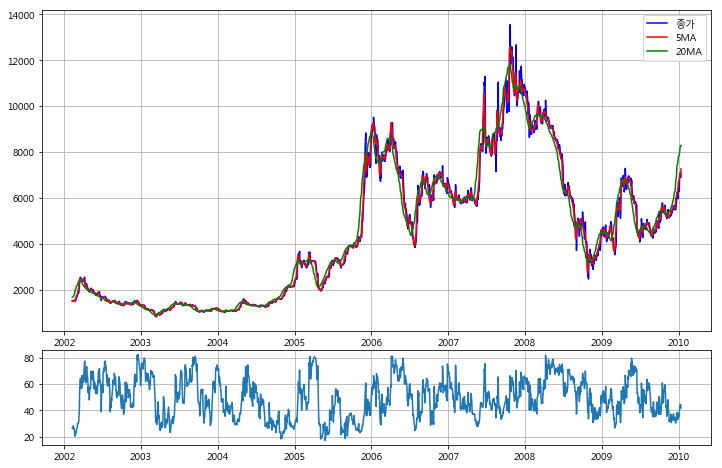

In [59]:
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10), sharex=True)
fig= plt.figure(figsize=(12,8))
ax1= plt.subplot2grid((4,4),(0,0), rowspan=3, colspan=4)
ax2= plt.subplot2grid((4,4),(3,0), rowspan=1, colspan=4)

ax1.plot(df['date'], df['종가'], color='b')
ax1.plot(df['date'], df['5MA'], color='r')
ax1.plot(df['date'], df['20MA'], color='g')
ax2.plot(df['date'], df['RSI'])
ax1.grid()
ax2.grid()
ax1.legend(loc='best')
plt.show()

In [4]:
# 종목정보를 읽어옴. 시가총액추가
def get_codes_pool():
    query= """
        select 시장구분, 종목코드, 종목명, 주식수, 전일종가*주식수 as 시가총액 from 종목코드 order by 시장구분, 종목코드
    """
    conn= mysqlconn()
    df= pdsql.read_sql_query(query, con=conn)
    conn.close()
    
    pool= dict()
    for idx, row in df.iterrows():
        시장구분, 종목코드, 종목명, 주식수, 시가총액 = row
        pool[종목코드]= [시장구분, 종목명, 주식수, 시가총액]
    return pool

# 시장 및 시가총액 범위로 조건을 제한하여 종목을 선정
def 시가총액(시장범위=['KOSPI', 'KOSDAQ'], 시가총액범위=[500, 3000]):
    _시장범위=["'%s'" % for i in 시장범위]
    query= """
        SELECT 시장구분, 종목코드, 종목명, 주식수, 감리구분, 상장일, 전일종가, CAST(((주식수*전일종가)/100000000 AS UNSIGNED)
        FROM 종목코드
        WHERE
            ((시장구분 IN (%s)))
    """ % (','.join(_시장범위), 시가총액범위[0], 시가총액범위[1])
    
    conn= mysqlconn()
    df= pdsql.read_sql_query(query, con=conn)
    conn.close()
    return df
# 위험성 높은 종목만 선정 (종목상태 LIKE, 증거금 100%)
def 시가총액_투기

   
#get_price(code=종목코드, 시작일자=None, 종료일자=None)
def get_price(code, 시작일자= None, 종료일자= None, param={}):
    SMA기간= 20
    LMA기간= 20
    
    try:
        SMA기간= param['SMA기간']
    except Exception as e:
        pass
    try:
        LMA기간= param['LMA기간']
    except Exception as e:
        pass
    
    if 시작일자 == None and 종료일자 == None:
        query="""
        SELECT 일자, 시가, 고가, 저가, 종가, 거래량 FROM 일별주가 WHERE 종목코드='%s' 
        ORDER BY 일자 ASC
        """ % (code)
    if 시작일자 != None and 종료일자 == None:
        query="""
        SELECT 일자, 시가, 고가, 저가, 종가, 거래량 FROM 일별주가 WHERE 종목코드='%s' AND 일자 >= '%s'
        ORDER BY 일자 ASC
        """ % (code, 시작일자)        
    if 시작일자 == None and 종료일자 != None:
        query="""
        SELECT 일자, 시가, 고가, 저가, 종가, 거래량 FROM 일별주가 WHERE 종목코드='%s' AND 일자 <= '%s'
        ORDER BY 일자 ASC
        """ % (code, 종료일자)
    if 시작일자 != None and 종료일자 != None:
        query="""
        SELECT 일자, 시가, 고가, 저가, 종가, 거래량 FROM 일별주가 WHERE 종목코드='%s' AND 일자 BETWEEN '%s' AND '%s'
        ORDER BY 일자 ASC
        """ % (code, 시작일자, 종료일자)
    
    conn= mysqlconn()
    df= pdsql.read_sql_query(query, con=conn)
    conn.close()
    
    df.fillna(0, inplace= True)
    df.set_index('일자', inplace= True)
    df['등락률']= (df['종가']-df['종가'].shift(1))/df['종가'].shift(1)
    df['전일등락률'] = df['등락률'].shift(1)
        
    df['전일시가']= df['시가'].shift(1)
    df['전일고가']= df['고가'].shift(1)
    df['전일저가']= df['저가'].shift(1)  
    df['전일종가']= df['종가'].shift(1)  
   
    df['SMA']= df['종가'].rolling(window= SMA기간).mean()
    df['전일SMA']= df['SMA'].shift(1)
    df['LMA']= df['종가'].rolling(window= LMA기간).mean()
    df['전일LMA']= df['LMA'].shift(1)
    df['RSI']= ta.RSI(np.array(df['종가'].astype(float)), timeperiod=14)
    df['전일RSI']= df['RSI'].shift(1)
    
    df.dropna(inplace= True)
    
    return df
     
    
    
    
       
        

SyntaxError: invalid syntax (<ipython-input-4-ae2b74fee4fa>, line 18)

In [ ]:
포트폴리오수 = 50
투자금=(10 * 10000 * 10000)//포트폴리오수
universe = get_codes(시총하한=500, 시총상한=3000)[:포트폴리오수]
종목별수익 = []

총손익, 이익거래횟수, 총거래횟수 = 0, 0, 0
for idx, row in universe[['종목코드','종목명']].iterrows():
    code, name = row
    robot = CRobotMinMax(종목코드=code)
    r = robot.run(투자시작일='2012-01-01', 투자종료일='2016-12-31', 투자금=투자금)
    if r == True:
        (_이익거래횟수, _총거래횟수, _총손익) = robot.report(out=False)
        이익거래횟수 = 이익거래횟수 + _이익거래횟수
        총거래횟수 = 총거래횟수 +_총거래횟수
        총손익 = 총손익 + _총손익
        종목별수익.append([name,_총손익])

df = DataFrame(data=종목별수익, columns=['종목명','수익'])

승률 = 이익거래횟수 / 총거래횟수    
print('승률(Percent Profit) %s/%s = %s' % (이익거래횟수, 총거래횟수, comma_percent(x=승률)))
print('총손익(Total Net Profit) %s' % comma_price(x=총손익))